In [539]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage import data, util, morphology
from skimage.measure import label, regionprops

If there exists files that already have the trained parameters you can load it by running this cell to get mean and covariance. Otherwise there will be a cell below that gives you the option to save the current parameters for future use.

In [540]:
def load_parameters():
    # Loading parameters
    orange_cone_rgb_mean = np.load('Data/Saved_Parameters/orange_cone_mean.npy')
    orange_cone_rgb_covariance = np.load('Data/Saved_Parameters/orange_cone_cov.npy')
    extra_cone_rgb_mean = np.load('Data/Saved_Parameters/extra_cone_rgb_mean.npy')
    extra_cone_rgb_covariance = np.load('Data/Saved_Parameters/extra_cone_rgb_covariance.npy')

# This is for getting labeled image's pixels
def get_labeled_images_pixels(labeled_folder):  
    roi_pixels = np.loadtxt(os.path.join(labeled_folder, os.listdir(labeled_folder)[0]))
    for index in range(1, len(os.listdir(labeled_folder))):
    #for index in range(1, 2):
        pixels_to_concat = np.loadtxt(os.path.join(labeled_folder, os.listdir(labeled_folder)[index]))
        roi_pixels = np.concatenate((roi_pixels, pixels_to_concat))
    return roi_pixels


cone_labeled_folder = 'Data/Cone_Labeled'
cone_roi_pixels = get_labeled_images_pixels(cone_labeled_folder)
#load_parameters()

Load image

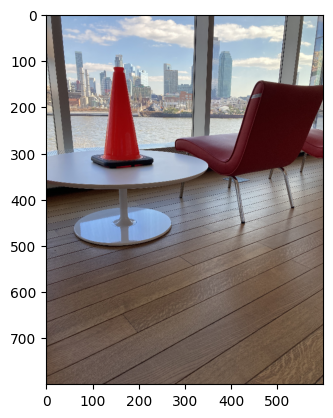

In [541]:
# This is for getting testing image
def get_test_image(test_folder, test_image):
    unlabeled_img = mpimg.imread(os.path.join(test_folder, test_image))
    
    return unlabeled_img

test_folder = 'Data/Test_Images'
unlabeled_folder = 'Data/ECE5242Proj1-train'
unlabeled_img = get_test_image(unlabeled_folder, 'train_4_dist5.png')  # THIS IS WHERE YOU 
plt.imshow(unlabeled_img)

Initialize the parameters with random values.

In [542]:
k = 2 # Number of Gaussian Distributions

weights = np.ones((1, k))
weights /= np.sum(weights) # Sum up to 1

mean_array = np.random.rand(k, 3, 1)

#covarianceSize = 3 # This could change
# cov = np.ones((k, covarianceSize, covarianceSize)) # Have to make covariance positive semi-definite which is required for gaussian
cov = np.array([np.eye(np.shape(unlabeled_img)[2]) for _ in range(k)]) # Restricted covariance using eye

Define the gaussian model for the Expectation step.

In [543]:
def Gaussian(pixel, mean, covariance):
    pixel = np.atleast_2d(pixel).T # Transpose first here to have math work for transpose in first mat mul
    mean = np.reshape(mean, np.shape(pixel))
    #D = np.shape(pixel)[1] # The number of color channels
    D = 3

    first_half = 1 / (((2 * np.pi) ** (D / 2)) * (np.linalg.det(covariance) ** (1 / 2))) # DET OF COVARIANCE GIVES ZERO LEADS TO ERROR

    first_mat_mul = np.matmul((pixel - mean).T, np.linalg.inv(covariance))
    second_mat_mul = np.matmul(first_mat_mul, (pixel - mean))
    second_half = np.exp((-1 / 2) * second_mat_mul)
    return first_half * second_half

In [544]:
# # # THIS IS FOR TESTING PURPOSES

# pixel = cone_roi_pixels[0]
# mean = mean_array[0]

# # cov = [[[0.10251908, 0.10251908, 0.10251908],
# #   [0.10251908, 0.10251908, 0.10251908],
# #   [0.10251908, 0.10251908, 0.10251908]],

# #  [[0.10518541, 0.10518541, 0.10518541],
# #   [0.10518541, 0.10518541, 0.10518541],
# #   [0.10518541, 0.10518541, 0.10518541]]]
# cov = np.array([np.eye(np.shape(unlabeled_img)[2]) for _ in range(k)])
# print(cov[0])
# Gaussian(pixel, mean, cov[0])

Define the max log likelihood for the Maximization step. Here we use the max log likelihood to calculate the responsibility matrix. The responsibility matrix is a 3D matrix with the dimensions of the image and the number of Gaussian distributions/classes. For each pixel, the responsibility matrix stores the responsibility of each Gaussian for that pixel. The responsibility of each Gaussian for a given pixel is proportional to the ratio of its probability density over the sum of all Gaussian probabilities at that pixel.

In [545]:
def Log_Likelihood(k, img, weights, mean, covariance):
    responsibility_matrix = np.zeros((img.shape[0], k)) # This is Z in the slides 

    # Loop through each pixel in image shape => (100000, 3)
    for row in range(img.shape[0]):
        prob_sum = 0 # Denominator in the E step slide(p_1 + p_2)

        for color_class in range(k):
            prob_sum +=  weights[0][color_class] * Gaussian(img[row], mean[color_class], covariance[color_class])[0][0]
        
        for color_class in range(k):
            responsibility_matrix[row][color_class] = (weights[0][color_class] * Gaussian(img[row], mean_array[color_class], cov[color_class])[0][0]) / prob_sum    
    
    return responsibility_matrix

In [546]:
# # THIS IS FOR TESTING PURPOSES
# mean = mean_array[0]

# # cov = [[[0.10251908, 0.10251908, 0.10251908],
# #   [0.10251908, 0.10251908, 0.10251908],
# #   [0.10251908, 0.10251908, 0.10251908]],

# #  [[0.10518541, 0.10518541, 0.10518541],
# #   [0.10518541, 0.10518541, 0.10518541],
# #   [0.10518541, 0.10518541, 0.10518541]]]
# cov = np.array([np.eye(np.shape(unlabeled_img)[2]) for _ in range(k)])
# responsibility_matrix = Log_Likelihood(2, cone_roi_pixels, weights, mean_array, cov)

Define the Expectation Step of the EM algorithm. The Expectation step computes the responsibility of each Gaussian distribution for each pixel. It calculates the sum of the probability density functions of each Gaussian at a given pixel, and the responsibility of each Gaussian is proportional to the ratio of its probability density over the sum of all Gaussian probabilities at that pixel.

To relate it to the class slides we are getting the latent variable.

In [547]:
def Expectation_Step(k, img, weights, mean_array, cov):
    return Log_Likelihood(k, img, weights, mean_array, cov)

Define the Maximization Step of the EM Algorithm. The Maximization step uses the responsibilty matrix computed in the Expectation-Step to update the parameters of each Gaussian distribution. This is done by re-estimating the mean, covariance, and weight of each Gaussian using the weighted sum of the data points. The weights are the responsibilities computed in the E-Step.

In [548]:
def Maximization_Step(k, img, responsibility_matrix):
    # this is Z_k in the maximization slide where Z_k = sum of all Z_i_k 
    # This value is used to calculate the new mean and covariance of each Gaussian distribution
    weighted_sum = np.sum(responsibility_matrix, axis=(0))

    new_mean = np.zeros((k, 1, 3))
    new_cov = np.zeros((k, 3, 3))

    # Calculate the new mean for each color class
    for color_class in range(k):
        latent_variable_sum = weighted_sum[color_class]  # This is Z for the specific cluster
        curr_mean = np.zeros((1, 3))

        for row in range(len(img)):
            pixel = np.atleast_2d(img[row]) # X in the slide
            curr_mean += responsibility_matrix[row][color_class] * pixel
        
        new_mean[color_class] = (curr_mean / latent_variable_sum) # Not sure if the transpose will mess up the calculations
    
    # Calculate new covariance 
    for color_class in range(k):
        latent_variable_sum = weighted_sum[color_class]  # This is Z for the specific cluster
        curr_cov = np.zeros((3, 3))

        for row in range(len(img)): # ERROR MIGHT BE HERE WITH CREATING ONE VAL!!!!!
            pixel = np.atleast_2d(img[row]).T # CHECK IF MADE SQUARE MATRIX WITH MEAN AND PIXEL and JUST ADDED TRANSPOSE JUST TO TEST
            temp_mean = np.reshape(new_mean[color_class], np.shape(pixel)) # THIS IS JUST TO TEST
            
            curr_cov += responsibility_matrix[row][color_class] * np.matmul((pixel - temp_mean), (pixel - temp_mean).T)
            # curr_cov += responsibility_matrix[row][color_class] * np.matmul((pixel - new_mean[color_class]), (pixel - new_mean[color_class]).T)
        
        new_cov[color_class] = curr_cov / latent_variable_sum
        # print("cov: ", new_cov[color_class])
    
    print(new_cov) # MIGHT HAVE TO RESHAPE MEAN
    
    return new_mean, new_cov


In [549]:
# # THIS IS FOR TESTING PURPOSES
# new_mean, new_cov = Maximization_Step(2, cone_roi_pixels, responsibility_matrix)

The EM algorithm iterates between the Expectation Step and the Maximization Step until the log-likelihood of the data given the estimated parameters converges to a maximum value.

In [550]:
def Gaussian_Mixture_Model(img, k, weights, mean_array, cov, num_iterations):
    original_shape = np.shape(mean_array)
    print("original_shape: ", original_shape)

    for iteration in range(num_iterations):
        print("before weights: ", np.shape(weights))
        print("before mean_array: ", np.shape(mean_array))
        print("before cov: ", np.shape(cov))
        print("before cov = ", cov)

        responsibility_matrix = Expectation_Step(k, img, weights, mean_array, cov)
        mean_array, cov = Maximization_Step(k, img, responsibility_matrix)
        
        mean_array = np.reshape(mean_array, original_shape) # THIS MIGHT NOT BE NEEDED
        print("After weights: ", np.shape(weights))
        print("After mean_array: ", np.shape(mean_array))
        print("After cov: ", np.shape(cov))
        print("after cov = ", cov)
    
    return weights, mean_array, cov

Run model on Orange Cone Region of Interest

In [551]:
weights, mean_array, cov = Gaussian_Mixture_Model(cone_roi_pixels, k, weights, mean_array, cov, 10)

original_shape:  (2, 3, 1)
before weights:  (1, 2)
before mean_array:  (2, 3, 1)
before cov:  (2, 3, 3)
before cov =  [[[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]]
[[[0.06666199 0.01293751 0.00391956]
  [0.01293751 0.01854692 0.01674772]
  [0.00391956 0.01674772 0.01747216]]

 [[0.06971345 0.01339589 0.0041345 ]
  [0.01339589 0.01883413 0.01704061]
  [0.0041345  0.01704061 0.01779136]]]
After weights:  (1, 2)
After mean_array:  (2, 3, 1)
After cov:  (2, 3, 3)
after cov =  [[[0.06666199 0.01293751 0.00391956]
  [0.01293751 0.01854692 0.01674772]
  [0.00391956 0.01674772 0.01747216]]

 [[0.06971345 0.01339589 0.0041345 ]
  [0.01339589 0.01883413 0.01704061]
  [0.0041345  0.01704061 0.01779136]]]
before weights:  (1, 2)
before mean_array:  (2, 3, 1)
before cov:  (2, 3, 3)
before cov =  [[[0.06666199 0.01293751 0.00391956]
  [0.01293751 0.01854692 0.01674772]
  [0.00391956 0.01674772 0.01747216]]

 [[0.06971345 0.01339589 0.0041345 ]
  [0.01339589 0.0188

/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_18859/2423820947.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  responsibility_matrix[row][color_class] = (weights[0][color_class] * Gaussian(img[row], mean_array[color_class], cov[color_class])[0][0]) / prob_sum
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_18859/2423820947.py:12: RuntimeWarning: overflow encountered in double_scalars
  responsibility_matrix[row][color_class] = (weights[0][color_class] * Gaussian(img[row], mean_array[color_class], cov[color_class])[0][0]) / prob_sum
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_18859/1827902231.py:16: RuntimeWarning: invalid value encountered in multiply
  curr_mean += responsibility_matrix[row][color_class] * pixel


[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
After weights:  (1, 2)
After mean_array:  (2, 3, 1)
After cov:  (2, 3, 3)
after cov =  [[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
before weights:  (1, 2)
before mean_array:  (2, 3, 1)
before cov:  (2, 3, 3)
before cov =  [[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]

 [[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]


/Users/kennethalvarez/opt/anaconda3/envs/ECE5242/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


KeyboardInterrupt: 

Now that you have the optimal mean and covariance save these parameters by running this cell.

In [ ]:
def save_parameters(weights, mean_array, cov):
    # Saving parameters to a file
    np.save('Data/Saved_Parameters/weights.npy', weights)
    np.save('Data/Saved_Parameters/mean_array.npy', mean_array)
    np.save('Data/Saved_Parameters/covariance.npy', cov)

save_parameters(weights, mean_array, cov)